## DQN Implementation without HER

### For comments and explanations please see [dqn-her.ipynb](dqn-her.ipynb)

In [67]:
%matplotlib inline

In [68]:
import gym
import math
import random
import numpy as np
# import matplotlib
import matplotlib.pyplot as plt

In [69]:
from collections import namedtuple
from itertools import count

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# import torchvision.transforms as T

In [73]:
# set up matplotlib
# is_ipython = 'inline' in matplotlib.get_backend()
# if is_ipython:
#     from IPython import display

# plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Bit flipping environment

In [74]:
class BitFlipEnv():
    
    def __init__(self, n = 8):
        self.n = n
        self.init_state = torch.randint(2, size=(n,))
        self.target_state = torch.randint(2, size=(n,))
        while np.array_equal(self.init_state, self.target_state):
            self.target_state = torch.randint(2, size=(n,))
        self.curr_state = self.init_state.clone()
        
    def step(self, action):
        self.curr_state[action] = 1 - self.curr_state[action]
        if np.array_equal(self.curr_state, self.target_state):
            return self.curr_state.clone(), 0
        else:
            return self.curr_state.clone(), -1
        
    def reset(self):
        self.init_state = torch.randint(2, size=(self.n,))
        self.target_state = torch.randint(2, size=(self.n,))
        while np.array_equal(self.init_state, self.target_state):
            self.target_state = torch.randint(2, size=(self.n,))
        self.curr_state = self.init_state.clone()

## Replay Memory

In [75]:
Transition = namedtuple('Transition', 
                       ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        """Saves a transition which should contain:
        - current state
        - action taken
        - next state
        - reward obtained"""
        self.memory.append(Transition(*args))
        if len(self.memory) > self.capacity:
            print('!!!!!memory capacity exceeded!')
            del self.memory[0]
        
    def sample(self, batch_size):
        """
        Returns batch_size number of samples from the replay memory
        """
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

## Q-Network in pytorch

In [76]:
class DQN(nn.Module):
    
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

## Feedforward network

In [77]:
NUM_BITS = 8
HIDDEN_SIZE = 256

In [78]:
class FNN(nn.Module):
    
    def __init__(self):
        super(FNN, self).__init__()
        self.ln1 = nn.Linear(NUM_BITS, HIDDEN_SIZE)
        self.ln2 = nn.Linear(HIDDEN_SIZE, NUM_BITS)
        
    def forward(self, x):
        x = F.relu(self.ln1(x))
        x = self.ln2(x)
        return x
    

## Hyper parameters

In [79]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.95
EPS_END = 0.05

TARGET_UPDATE = 200
MODEL_PATH = '_dqn_policy_net.pt'
WEIGHTS_PATH = '_dqn_policy_net_weights.pt'
FIGURE_PATH = '_dqn.png'
SAVE_MODEL = True
steps_done = 0

## Initialize Model

In [80]:
policy_net = FNN().to(device)
target_net = FNN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(1e6)

## Helper functions

In [81]:
def select_action(state, greedy=False):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if greedy:
        with torch.no_grad():
            return policy_net(state.float()).argmax().view(1,1)
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state.float()).argmax().view(1,1)
    else: 
        return torch.tensor([[random.randrange(NUM_BITS)]], device=device, dtype=torch.long)

In [86]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, 
                                           batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.stack([s for s in batch.next_state 
                                      if s is not None])
    
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch.float()).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states.float()).max(1)[0].detach()
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.float()
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [87]:
CHECK_RATE = 500
num_episodes = 30000
EPS_DECAY = num_episodes * NUM_BITS * 0.25
env = BitFlipEnv(NUM_BITS)
success = 0
episodes = []
success_rate = []
for i_episode in range(num_episodes):
    env.reset()
    state = env.init_state
    goal = env.target_state
    transitions = []
    episode_success = False
    for t in range(NUM_BITS):
        if episode_success:
            continue
        action = select_action(state)
        next_state, reward = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        memory.push(state, action, next_state, reward)
        
        state = next_state
        
        optimize_model()
        if reward == 0:
            if episode_success:
                continue
            else:
                episode_success = True
                success += 1
        
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
#         print(i_episode, end=' ')
    if i_episode % CHECK_RATE == 0:
        print('success rate for last {} episodes after {} episodes of training: {}%'.format(CHECK_RATE, i_episode, success/CHECK_RATE * 100))
        success_rate.append(success/CHECK_RATE)
        episodes.append(i_episode)
        success = 0

episodes.append(num_episodes)
success_rate.append(success/CHECK_RATE)

RuntimeError: Expected object of scalar type Float but got scalar type Long for argument #2 'mat1' in call to _th_addmm

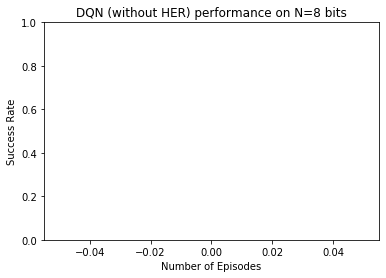

In [84]:
fig = plt.figure(1)
plt.plot(episodes, success_rate)
plt.title('DQN (without HER) performance on N={} bits'.format(NUM_BITS))
plt.ylabel('Success Rate')
plt.xlabel('Number of Episodes')
plt.ylim([0, 1])
if SAVE_MODEL:
    plt.savefig(str(NUM_BITS)+FIGURE_PATH)
# plt.show()

In [85]:
if SAVE_MODEL:
    torch.save(policy_net.state_dict(), str(NUM_BITS)+WEIGHTS_PATH)
    print('Weights saved')
    torch.save(policy_net, str(NUM_BITS)+MODEL_PATH)
    print('Model saved')

print('Complete')  

Weights saved
Model saved
Complete


/Users/leiyou/anaconda3/envs/tensorforce/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/leiyou/anaconda3/envs/tensorforce/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [18]:
successes = 0
for i in range(10000):
    env.reset()
    test_state = env.init_state
    goal_state = env.target_state
#     print('#############################################')
#     print('start', test_state)
#     print('goal', goal_state)
    next_state = test_state.clone()
    for i in range(NUM_BITS):
        action = select_action(next_state, greedy=True)
        next_state, reward = env.step(action.item())
#         print('taking action', action)
#         print('next state', next_state)
        if np.array_equal(next_state, goal_state):
            successes += 1
            break
print(successes)

52
